In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import ast
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

In [2]:
# Load datasets

# Train Data
temp_df = pd.read_csv("/content/train.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("/content/train.csv", usecols=columns_to_use)

# Test Data
test_data = pd.read_csv("/content/test.csv", usecols=columns_to_use)


# Dropping the columns that are not relevant to our analysis
train_data = train_data.drop(columns=['building_name', 'site_name','date'])
test_data = test_data.drop(columns=['building_name', 'site_name','date'])



train_data = train_data[(train_data['meter'] == 'electricity') | (train_data['meter'] == 'chilledwater')
| (train_data['meter'] == 'hotwater') | (train_data['meter'] == 'gas')]

test_data = test_data[(test_data['meter'] == 'electricity') | (test_data['meter'] == 'chilledwater')
| (test_data['meter'] == 'hotwater') | (test_data['meter'] == 'gas')]


# Building index on building_id for furhter assessment
train_data.set_index('building_id', inplace=True)
test_data.set_index('building_id', inplace=True)

In [3]:
# Inspecting the data frames
print(train_data.sample(2))
print('-------------------------------------------------------------')
print(test_data.sample(2))

                    meter  meter_reading sub_primaryspaceusage     sqm  \
building_id                                                              
142          chilledwater     18168.5645     College Classroom  5117.7   
278           electricity       674.6900     College Classroom  4106.6   

                sqft     timezone  airTemperature  cloudCoverage  \
building_id                                                        
142          55087.0   US/Central       19.700219       1.754854   
278          44203.0  US/Mountain       20.743077       1.994827   

             dewTemperature  precipDepth1HR  precipDepth6HR  seaLvlPressure  \
building_id                                                                   
142               13.127193         0.90377       11.683435     1017.646783   
278               13.989670         0.73467       11.524903     1016.445906   

             windDirection  windSpeed season  site_id  
building_id                                            
1

In [4]:
# Define features and types based on dataset
numerical_features = ['sqm', 'sqft', 'airTemperature', 'cloudCoverage', 'dewTemperature',
                      'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']
categorical_features = ['timezone', 'season', 'sub_primaryspaceusage', 'site_id']

## LightGBM

### Light GBM for all meter values with hyperparameter tuning

In [5]:


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9],
}


unique_meters = train_data['meter'].unique()
results = []

for meter_value in unique_meters:
    print(f"Processing meter value: {meter_value}")

    # Splitting data for the specific meter value
    X = train_data[train_data['meter'] == meter_value].drop(columns=['meter_reading', 'meter'])
    y = train_data[train_data['meter'] == meter_value]['meter_reading']

    # Convert 'site_id' from numeric to categorical
    X['site_id'] = X['site_id'].astype('category')

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and apply preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Scale the target variable
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1, 1))

    # Preparing dataset for LightGBM
    model = LGBMRegressor(boosting_type='gbdt', force_col_wise=True)

    # Set up GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

    # Fit the grid search to the data
    grid.fit(X_train_processed, y_train_scaled.flatten())

    # Get the best parameters
    best_params = grid.best_params_

    # Train a final model with the best parameters
    final_model = LGBMRegressor(boosting_type='rf', force_col_wise=True, **best_params)
    final_model.fit(X_train_processed, y_train_scaled.flatten())

    # Model prediction and evaluation
    y_pred_scaled = final_model.predict(X_test_processed)
    rsquared = r2_score(y_test_scaled, y_pred_scaled)


    results.append({
        'meter_value': meter_value,
        'best_params': best_params,
        'r-squared': rsquared
    })

# Convert results to a DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)

Processing meter value: electricity
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 117900, number of used features: 48
[LightGBM] [Info] Start training from score 0.023886
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 117901, number of used features: 48
[LightGBM] [Info] Start training fr

In [6]:


results_df['best_params'] = results_df['best_params'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert the DataFrame to a dictionary where keys are meter values and values are the best parameter sets
best_params_dict = pd.Series(results_df.best_params.values, index=results_df.meter_value).to_dict()

results = []
for meter_value in unique_meters:
    print(f"Fitting model for meter type: {meter_value}")

    # Filtering and preprocessing the training data
    X_train = train_data[train_data['meter'] == meter_value].drop(columns=['meter_reading', 'meter'])
    y_train = train_data[train_data['meter'] == meter_value]['meter_reading']
    X_train['site_id'] = X_train['site_id'].astype('category')  # Convert 'site_id' to categorical

    # Apply the same preprocessing as before
    X_train_processed = preprocessor.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))

    # Filtering and preprocessing the test data
    X_test = test_data[test_data['meter'] == meter_value]
    X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical
    X_test_processed = preprocessor.transform(X_test)

    # Define and train the final model using the best parameters found for this meter type
    best_params = best_params_dict[meter_value]  # Retrieve best parameters for the current meter type
    final_model = LGBMRegressor(boosting_type='rf', force_col_wise=True, **best_params)
    final_model.fit(X_train_processed, y_train_scaled.flatten())

    # Predict on the test dataset
    y_pred_scaled = final_model.predict(X_test_processed)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Convert predictions back to original scale

    results.append({
        'meter_value': meter_value,
        'predictions': y_pred.flatten()
    })


Fitting model for meter type: electricity


<ipython-input-6-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 221064, number of used features: 48
[LightGBM] [Info] Start training from score 0.023762
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: chilledwater


<ipython-input-6-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 85644, number of used features: 36
[LightGBM] [Info] Start training from score 0.006903
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: gas


<ipython-input-6-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 36600, number of used features: 27
[LightGBM] [Info] Start training from score 0.020306
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: hotwater


<ipython-input-6-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 29646, number of used features: 31
[LightGBM] [Info] Start training from score 0.016716
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [7]:


# Ensure results is a list containing dictionaries with 'meter_value' and 'predictions'
metrics = []  # This will store the extended results including the new metrics
meter_predictions = []  # This will store the meter, predictions, y_true, and building IDs

for result in results:
    meter_value = result['meter_value']
    predictions = result['predictions']

    # Extract the actual values from the test data
    y_true = test_data[test_data['meter'] == meter_value]['meter_reading'].values  # Ensure this column name matches your actual data
    building_ids = test_data[test_data['meter'] == meter_value].index.values  # Extract building IDs

    # Check if y_true and predictions have the same length
    if len(predictions) != len(y_true):
        print(f"Error: Mismatched number of predictions and true values for meter {meter_value}")
        continue  # Skip to the next loop iteration

    # Calculate metrics
    mse = mean_squared_error(y_true, predictions)
    r_squared = r2_score(y_true, predictions)
    negative_mse = -mse

    # Update the metrics with the new values
    metrics.append({
        'meter_value': meter_value,
        'mse': mse,
        'r_squared': r_squared,
        'negative_mse': negative_mse
    })

    # Store meter, predictions, y_true, and building IDs in a list of dictionaries
    for i in range(len(predictions)):
        meter_predictions.append({
            'meter_value': meter_value,
            'predictions': predictions[i],
            'y_true': y_true[i],
            'building_id': building_ids[i]
        })

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Convert meter, predictions, y_true, and building IDs to a DataFrame
meter_predictions_df = pd.DataFrame(meter_predictions)

# Print both DataFrames
print("Metrics DataFrame:")
print(metrics_df)
print("\nMeter, Predictions, y_true, and Building IDs DataFrame:")
print(meter_predictions_df)


Metrics DataFrame:
    meter_value           mse  r_squared  negative_mse
0   electricity  9.503506e+06   0.818345 -9.503506e+06
1  chilledwater  1.409652e+13   0.725804 -1.409652e+13
2           gas  7.274804e+08   0.726157 -7.274804e+08
3      hotwater  2.266721e+12   0.601367 -2.266721e+12

Meter, Predictions, y_true, and Building IDs DataFrame:
        meter_value   predictions     y_true  building_id
0       electricity    538.943880     2.1775            1
1       electricity    538.943880     2.7925            1
2       electricity    538.943880     7.1100            1
3       electricity    538.943880     6.8450            1
4       electricity    538.943880     3.9500            1
...             ...           ...        ...          ...
371930     hotwater  59413.540739  1626.9840          593
371931     hotwater  59413.540739  1626.9840          593
371932     hotwater  59413.540739  1626.9840          593
371933     hotwater  59413.540739  1626.9840          593
371934     

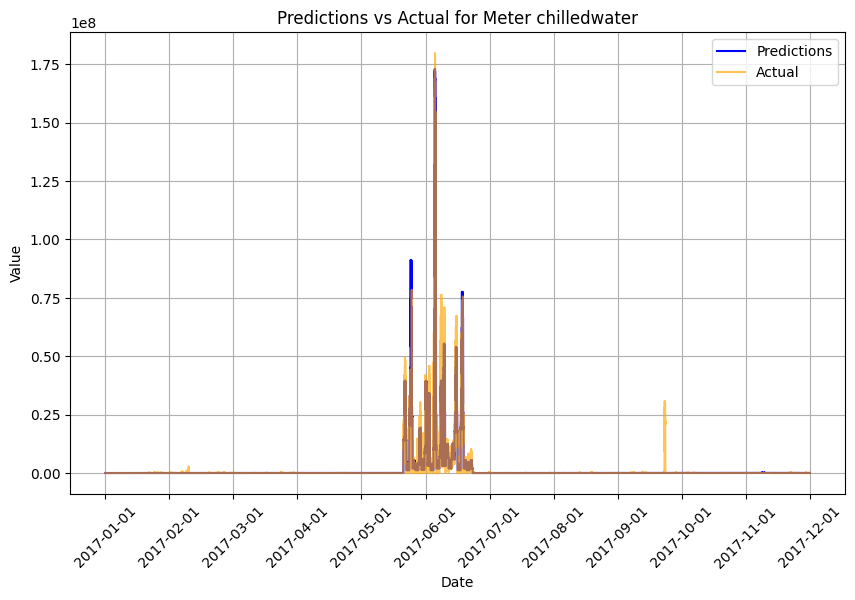

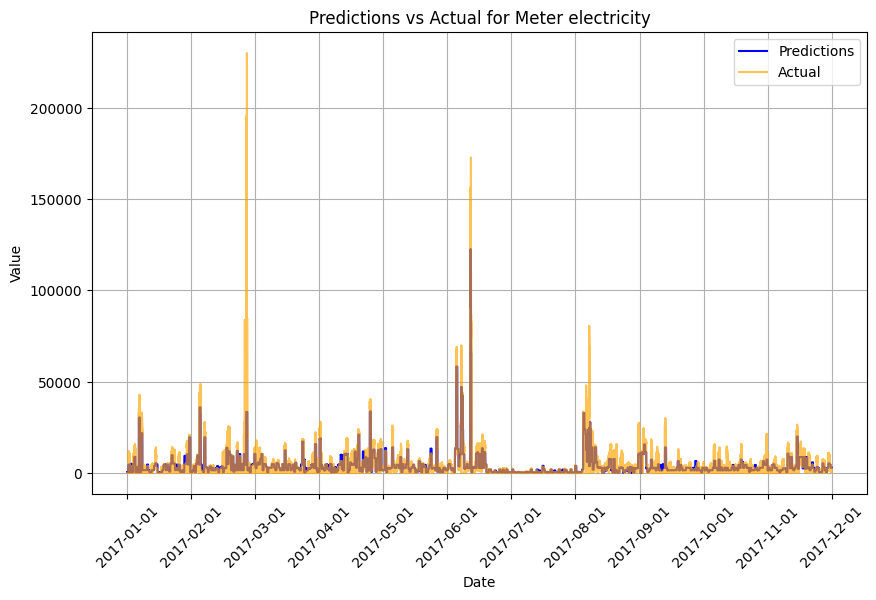

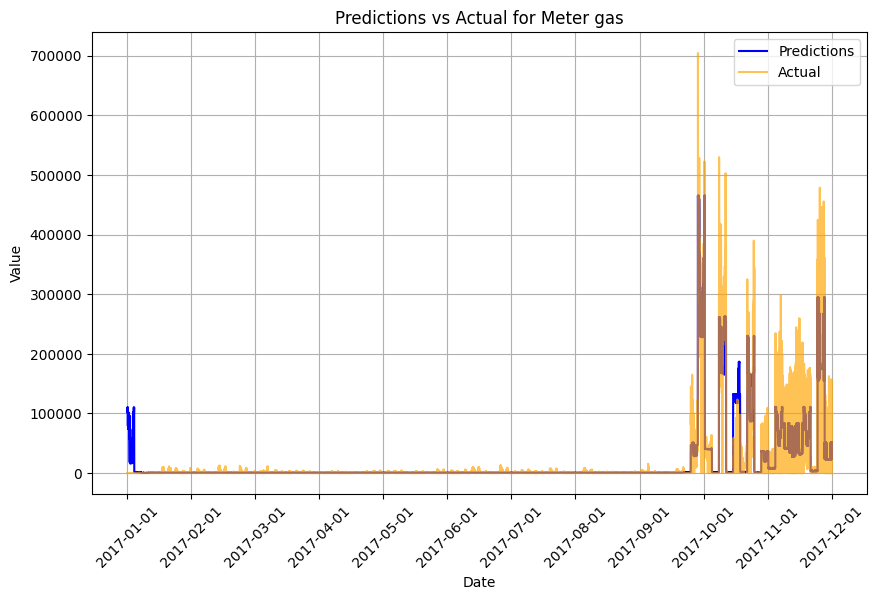

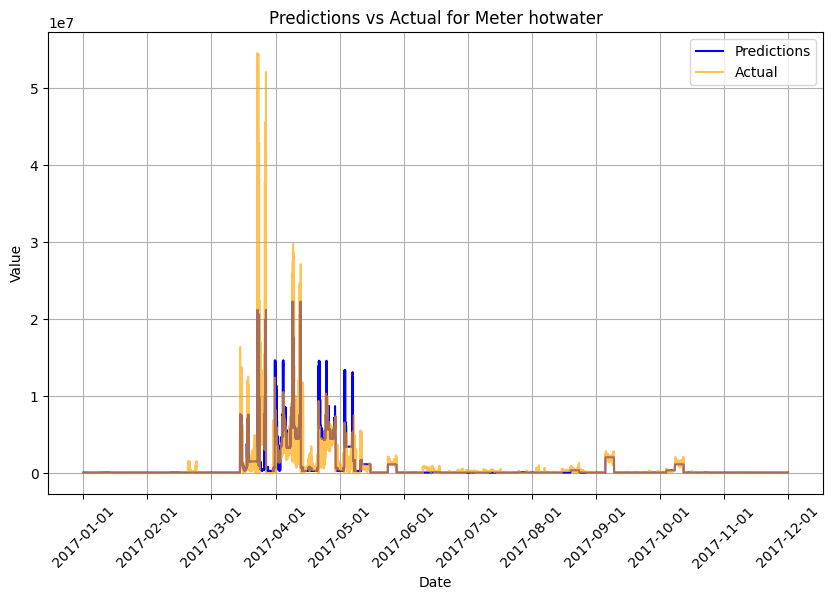

In [8]:


# Group the data by 'meter_value'
grouped_data = meter_predictions_df.groupby('meter_value')

# Plot y_true against predictions for each meter
for meter_value, group in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(group.index, group['predictions'], label='Predictions', color='blue', alpha=1)  # Set opacity for predictions
    plt.plot(group.index, group['y_true'], label='Actual', color='orange', alpha=0.67)  # Set opacity for y_true
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Predictions vs Actual for Meter {meter_value}')
    plt.legend()

   # Set x-axis ticks
    start_date = pd.Timestamp('2017-01-01')
    x_ticks = np.linspace(0, len(group.index) - 1, 12, dtype=int)  # Calculate 12 equally spaced ticks
    date_labels = [(start_date + DateOffset(months=i)).strftime('%Y-%m-%d') for i in range(12)]  # Generate date labels
    plt.xticks(group.index[x_ticks], date_labels, rotation=45)  # Rotate x-axis labels by 45 degrees

    plt.grid(True)
    plt.show()


In [9]:
# Group the data by 'meter_value' and 'building_id' and sum the predictions
sum_predictions = meter_predictions_df.groupby(['meter_value', 'building_id'])['predictions'].sum().reset_index()

sum_predictions.to_csv("./Building_Energy_Predictions.csv")
